# Environment Setup (Kernel)

## What you need to download/install
1. **Anaconda** or **Miniconda3**
2. **VSCode**
3. VSCode Extensions:
   - **Python** (Microsoft)
   - **Jupyter** (Microsoft)


## Create a portable Conda environment (recommended)

### 1) Open a terminal
- Windows: Anaconda Prompt or VS Code Terminal
- macOS/Linux: Terminal or VS Code Terminal

### 2) Create the environment
```bash
conda create -n diabetes-mvp python=3.10 -y
conda activate diabetes-mvp
conda install -y numpy pandas matplotlib scikit-learn jupyter ipykernel streamlit joblib imbalanced-learn
python -m ipykernel install --user --name diabetes-mvp --display-name "Python (diabetes-mvp)"
```

### 3) Select the environment
1. Click **Select Kernel** (top-right of the notebook)
2. Choose **Python (diabetes-mvp)**

In [1]:
### Test system is working

import sys
print("Python version:", sys.version)
print("Executable:", sys.executable)

Python version: 3.10.19 (main, Oct 21 2025, 16:43:05) [GCC 11.2.0]
Executable: /home/ojanen/miniconda3/envs/diabetes-mvp/bin/python


# Import libraries

In [88]:
### Imports

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib

from imblearn.over_sampling import SMOTENC
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures, OrdinalEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    classification_report,
    recall_score,
    precision_score,
    accuracy_score,
    f1_score
)


# Data

##### 
Download the dataset manually from kaggle and place it in the same folder as this file

Dataset url: https://www.kaggle.com/datasets/iammustafatz/diabetes-prediction-dataset/data

In [3]:
### Load dataset

filename = "diabetes_prediction_dataset.csv" # change this if you changed the dataset file name

df = pd.read_csv(filename)
print(df.head())

   gender   age  hypertension  heart_disease smoking_history    bmi  \
0  Female  80.0             0              1           never  25.19   
1  Female  54.0             0              0         No Info  27.32   
2    Male  28.0             0              0           never  27.32   
3  Female  36.0             0              0         current  23.45   
4    Male  76.0             1              1         current  20.14   

   HbA1c_level  blood_glucose_level  diabetes  
0          6.6                  140         0  
1          6.6                   80         0  
2          5.7                  158         0  
3          5.0                  155         0  
4          4.8                  155         0  


In [4]:
random_row = df.sample(n=1)
print(random_row)

       gender   age  hypertension  heart_disease smoking_history    bmi  \
20129  Female  65.0             0              0         current  27.32   

       HbA1c_level  blood_glucose_level  diabetes  
20129          3.5                   80         0  


In [5]:
### Display dataset info

df.info()
df.describe()
df["diabetes"].value_counts()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   gender               100000 non-null  object 
 1   age                  100000 non-null  float64
 2   hypertension         100000 non-null  int64  
 3   heart_disease        100000 non-null  int64  
 4   smoking_history      100000 non-null  object 
 5   bmi                  100000 non-null  float64
 6   HbA1c_level          100000 non-null  float64
 7   blood_glucose_level  100000 non-null  int64  
 8   diabetes             100000 non-null  int64  
dtypes: float64(3), int64(4), object(2)
memory usage: 6.9+ MB


diabetes
0    91500
1     8500
Name: count, dtype: int64

# Preprocessing

In [6]:
### Split dataset

X = df.drop("diabetes", axis=1) # features
y = df["diabetes"] # target

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2, # test data amount
    random_state=42, # reproducibility
    stratify=y # preserves class balance
)

X_tr, X_val, y_tr, y_val = train_test_split(
    X_train,
    y_train,
    test_size=0.2,
    stratify=y_train,
    random_state=42
)


In [101]:
### Prepocess dataset

# Define columns
text_cols = ["gender", "smoking_history"] # Categorical textual features
bin_cols = ["hypertension", "heart_disease"] # Binary categorical features 
num_cols = ["age", "bmi", "HbA1c_level", "blood_glucose_level"] # Numerical features

numeric_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    #("poly", PolynomialFeatures(degree=2, interaction_only=True, include_bias=False))
])

preprocess = ColumnTransformer([
    ("num", numeric_pipeline, num_cols),
    ("bin", "passthrough", bin_cols),
    ("text", OneHotEncoder(drop="first", handle_unknown="ignore"), text_cols)
])

# Model (AI Component)

Best params: {'log_clf__C': 5, 'log_clf__class_weight': None, 'log_clf__penalty': 'l2'}
Best CV F1: 0.737318998886409
Best threshold on VAL (by F1): 0.47
Validation F1 at best threshold: 0.7603

Final TEST metrics (using val-chosen threshold):
Accuracy: 0.9618
Precision: 0.8545454545454545
Recall: 0.6635294117647059
F1: 0.7470198675496689

Classification report (TEST):
              precision    recall  f1-score   support

           0       0.97      0.99      0.98     18300
           1       0.85      0.66      0.75      1700

    accuracy                           0.96     20000
   macro avg       0.91      0.83      0.86     20000
weighted avg       0.96      0.96      0.96     20000



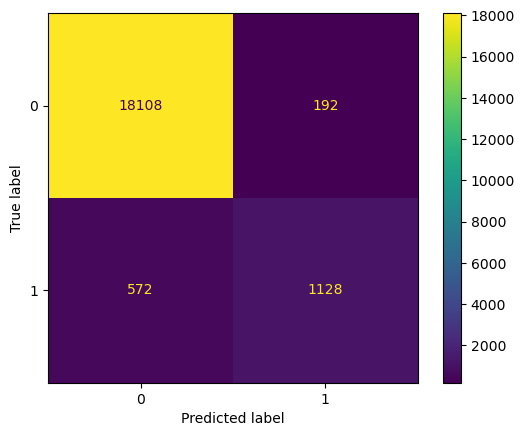

In [342]:
### Hyperparameter tuning using GridSearchCV

# RUN ONLY WHEN OPTIMISING THE MODEL TO FIND THE BEST PARAMETERS TAKES 5-10MINS

# This section finds the best Logistic Regression settings
# (C, penalty type, and class_weight) using cross-validation
# and optimizes for F1-score (important for imbalanced data).

# Create a pipeline: preprocessing + logistic regression model
pipe_clf_best = Pipeline([
    ("preprocess", preprocess), # Apply scaling and encoding
    ("log_clf", LogisticRegression(
        solver="saga", # Optimization algorithm
        max_iter=5000, # Max training iterations
        random_state=42 # Reproducibility
    ))
])

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

param_grid = [
    {"log_clf__class_weight": [None, "balanced"],
     "log_clf__penalty": ["l2"],
     "log_clf__C": [0.1, 0.5, 1, 2, 5, 10]},
    
    {"log_clf__class_weight": [None, "balanced"],
     "log_clf__penalty": ["l1"],
     "log_clf__C": [0.1, 0.5, 1, 2, 5, 10]},
    
    {"log_clf__class_weight": [None, "balanced"],
     "log_clf__penalty": ["elasticnet"],
     "log_clf__l1_ratio": [0.2, 0.5, 0.8],
     "log_clf__C": [0.1, 0.5, 1, 2, 5, 10]},
]

search = GridSearchCV(
    pipe_clf_best,
    param_grid=param_grid,
    scoring="f1",
    cv=cv,
    n_jobs=-1,
    refit=True
)

search.fit(X_tr, y_tr)

print("Best params:", search.best_params_)
print("Best CV F1:", search.best_score_)

best_model = search.best_estimator_

proba_val = best_model.predict_proba(X_val)[:, 1]
thresholds = np.arange(0.05, 0.95, 0.01)

best_t = None
best_f1 = -1

for t in thresholds:
    y_val_pred = (proba_val >= t).astype(int)
    f1 = f1_score(y_val, y_val_pred)
    if f1 > best_f1:
        best_f1 = f1
        best_t = t

print(f"Best threshold on VAL (by F1): {best_t:.2f}")
print(f"Validation F1 at best threshold: {best_f1:.4f}")

proba_test = best_model.predict_proba(X_test)[:, 1]
y_test_pred = (proba_test >= best_t).astype(int)

print("\nFinal TEST metrics (using val-chosen threshold):")
print("Accuracy:", accuracy_score(y_test, y_test_pred))
print("Precision:", precision_score(y_test, y_test_pred))
print("Recall:", recall_score(y_test, y_test_pred))
print("F1:", f1_score(y_test, y_test_pred))

print("\nClassification report (TEST):")
print(classification_report(y_test, y_test_pred))

ConfusionMatrixDisplay.from_predictions(y_test, y_test_pred)


In [102]:
### Train Logistic Regression

# Create a pipeline: preprocessing + logistic regression model
pipe_clf = Pipeline([
    ("preprocess", preprocess), # Apply scaling and encoding
    ("log_clf", LogisticRegression(
        class_weight={0:1, 1:4}, # Handle class imbalance 
        solver="saga", # Optimization algorithm
        penalty="l2",
        C=3.0,
        max_iter=5000, # Max training iterations
        random_state=42 # Reproducibility
    ))
])

# Fit the pipeline on training data
pipe_clf.fit(X_tr, y_tr)

,steps,"[('preprocess', ...), ('log_clf', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('bin', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


# Evaluation & Validation

In [103]:
### Validation

proba_val = pipe_clf.predict_proba(X_val)[:, 1]


thresholds = np.arange(0.1, 0.9, 0.01)

best_threshold = 0
best_f1 = 0

for t in thresholds:
    y_val_pred = (proba_val >= t).astype(int)
    f1 = f1_score(y_val, y_val_pred)

    if f1 > best_f1:
        best_f1 = f1
        best_threshold = t

print("Best threshold:", best_threshold)
print("Best validation F1:", best_f1)

Best threshold: 0.7999999999999996
Best validation F1: 0.7379221889696451


In [104]:
### Accuracy 

train_acc = pipe_clf.score(X_train, y_train)
test_acc  = pipe_clf.score(X_test, y_test)

print(f"Train Accuracy: {train_acc:.2%}")
print(f"Test  Accuracy: {test_acc:.2%}")

Train Accuracy: 93.74%
Test  Accuracy: 93.97%


In [105]:
### Precision and Recall

proba_test = pipe_clf.predict_proba(X_test)[:, 1]

threshold = 0.6 # Change this acording to the treshold optimization test

y_test_pred = (proba_test >= threshold).astype(int)

# Print results
print("Accuracy:", accuracy_score(y_test, y_test_pred))
print("Precision:", precision_score(y_test, y_test_pred))
print("Recall:", recall_score(y_test, y_test_pred))
print("F1:", f1_score(y_test, y_test_pred))

print("\nClassification Report (Optimized Threshold):")
print(classification_report(y_test, y_test_pred))

Accuracy: 0.9508
Precision: 0.6986681465038845
Recall: 0.7405882352941177
F1: 0.7190177041690463

Classification Report (Optimized Threshold):
              precision    recall  f1-score   support

           0       0.98      0.97      0.97     18300
           1       0.70      0.74      0.72      1700

    accuracy                           0.95     20000
   macro avg       0.84      0.86      0.85     20000
weighted avg       0.95      0.95      0.95     20000



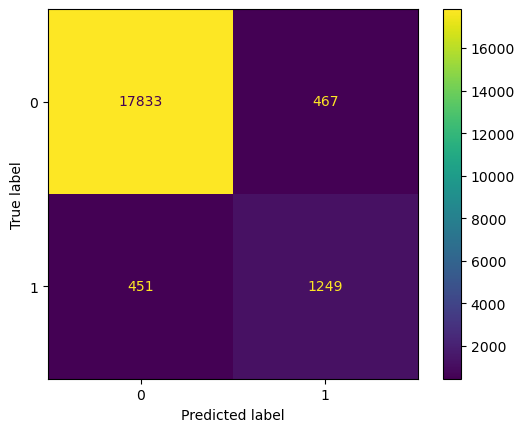

In [15]:
### Confusion Matrix

ConfusionMatrixDisplay.from_predictions(y_test, y_test_pred)

In [16]:
### Cross validation

scores = cross_val_score(pipe_clf, X_train, y_train, cv=3, verbose=3)

print("CV Accuracy:", scores)
print("Mean Accuracy:", scores.mean())

[CV] END ................................ score: (test=0.962) total time=  16.0s
[CV] END ................................ score: (test=0.962) total time=  12.7s
[CV] END ................................ score: (test=0.961) total time=  17.9s
CV Accuracy: [0.96171298 0.96186298 0.96107403]
Mean Accuracy: 0.9615499940504101


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   46.7s finished


In [351]:
### Save the pipeline model

# Save the full pipeline (preprocessing + model) to a file
joblib.dump(pipe_clf, "diabetes_logreg_pipeline.joblib")
print("Saved: diabetes_logreg_pipeline.joblib")

Saved: diabetes_logreg_pipeline.joblib


# UI

Implemented on UI.py file

Remember to check that VS Code is using the same Python interpreter as the diabetes_project kernel:

1) Press Ctrl+Shift+P
2) Type "Python: Select Interpreter"
3) Choose the interpreter that matches your diabetes_project environment
4) Reload the window if needed

To run the UI.py open terminal and run
 1) conda activate diabetes-mvp
 2) python UI.py